# Sparkling Titanic

In [134]:
# imports
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from graphframes import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# make graphs beautiful
plt.style.use('ggplot')
plt.rc('font', family='sans-serif') 
%matplotlib inline

ImportError: No module named 'graphframes'

In [47]:
sqlContext = SQLContext(sc)
    
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


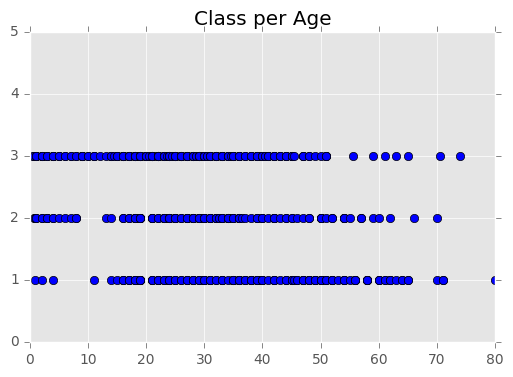

In [48]:
sorted_by_age = train.sort_values(['Age'])
plt.plot(sorted_by_age.Age, sorted_by_age.Pclass, 'bo')
plt.title('Class per Age')
plt.ylim([0, 5])
plt.show()

In [49]:
# drop useless columns
drop_elements = ['PassengerId', 'Name']
train = train.drop(drop_elements, axis = 1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Here, I want to find the percentance of people that survived based on their class  
**pclass**: A proxy for socio-economic status (SES)  

    1st = Upper
    2nd = Middle
    3rd = Lower

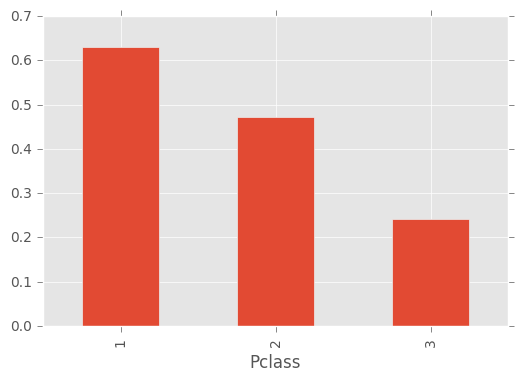

In [50]:
total_elements = train.groupby(train.Pclass).Survived.count()
total_survived = train[train.Survived == 1].groupby(train.Pclass).Survived.count()
(total_survived / total_elements).plot.bar()

As expected, most of the upper class survived, while the lower class had less odds to survive.

Now, I am interested on the average price per ticket for each class.

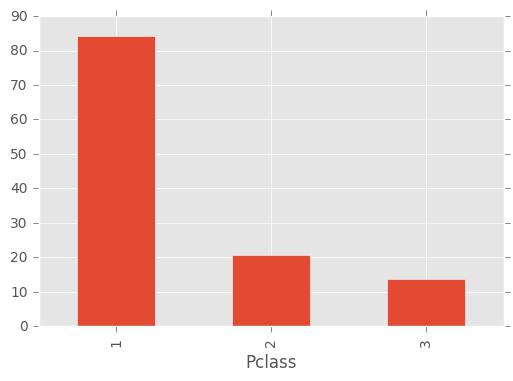

In [51]:
avg_prices = train.groupby(train.Pclass).Fare.mean()
avg_prices.plot.bar()

In [52]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = spark.read.csv('train.csv', header='true', inferSchema='true')

In [53]:
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [54]:
df.dtypes

[('PassengerId', 'int'),
 ('Survived', 'int'),
 ('Pclass', 'int'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string')]

In [60]:
df.filter((df.Survived == 1) & (df.Sex == 'male')).count() / df.filter(df.Sex == 'male').count()

0.18890814558058924

In [108]:
df.filter((df.Survived == 1) & (df.Sex == 'female')).count() / df.filter(df.Sex == 'female').count()

0.7420382165605095

In [110]:
total_by_sex = df.groupBy(df.Sex).count().withColumnRenamed('count', 'total')
survived_by_sex = df.filter(df.Survived == 1).groupBy(df.Sex).count()
survived_by_sex.join(total_by_sex, survived_by_sex.Sex == total_by_sex.Sex, 'outer')\
    .rdd.map(lambda x: (x.Sex, x['count'] / x.total)).collect()

[('female', 0.7420382165605095), ('male', 0.18890814558058924)]

In [117]:
# best way to do this calculation
df[["Sex", "Survived"]].groupby('Sex').mean().show()

+------+-------------------+
|   Sex|      avg(Survived)|
+------+-------------------+
|female| 0.7420382165605095|
|  male|0.18890814558058924|
+------+-------------------+



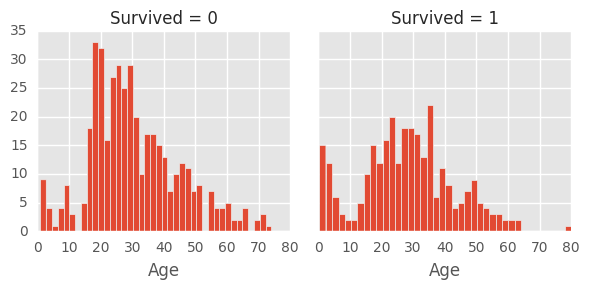

In [126]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=40)

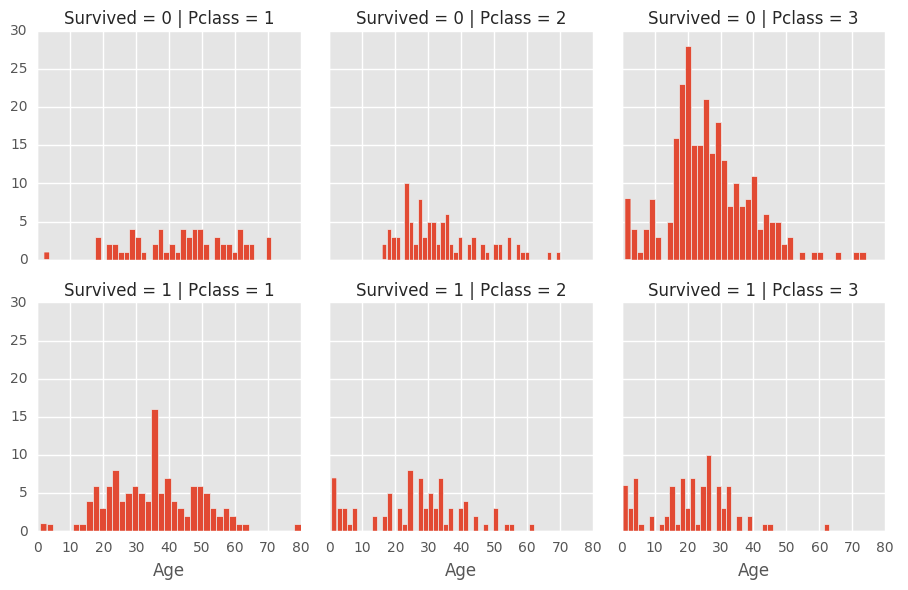

In [133]:
grid = sns.FacetGrid(train, col='Pclass', row='Survived')
grid.map(plt.hist, 'Age', bins=40)
grid.add_legend();